# Ход решения
## Содержание
В данном ноутбуке представлен код создания всех признаков и обучения модели.  
**В ячейках местами присутствуют комментарии мотивирующие дальнейшие действия.**  
Для хранения промежуточных данных использовались внешние файлы, 
общий объем которых превышает несколько гигабайт, что делает 
трудноосуществимым их передачу вместе с этим `.ipynb` файлом.
1. [Первые наблюдения](#top)  
Общий взгляд на данные, первичные графики и анализ
1. [Кодирование категориальных признаков](#OHE)  
Перекодирование выбора персонажей / режима игры в one-hot представление, анализ выбора персонажей
1. [Статистика по игрокам](#add-ohe-to-main)  
Анализ винрейтов игроков и числа игр у каждого
1. [Синергия и контр-пики героев](#hero-synergy-\/-hero-counters)  
Реализация признаков из литературы
1. [Рейтинг](#rating)  
Анализ изменения рейтинга игроков между играми и создание признаков этого  
Файл `rating.py` использовался для генерации основных данных
1. [Обучение модели](#models-and-training)  
Создание финальных комбинированных признаков и обучение бустинга

## Идея решения
В ходе изучения данных и построения различных дополнительных признаков была 
обнаружена сильная зависимость между рейтингом и итоговым результатом.  
Интуитивно понятно, что рейтинг должен расти после победы и падать после проигрыша.  
Дополнительное смятение принесло описание признака X21 (время игры), которое можно двояко трактовать 
как продолжительность конкретного матча (это первое что приходит на ум) и как временную метку игры.  
Руководствуясь вторым смыслом я построил график зависимости рейтинга от времени и заметил сильную 
зависимость, на её основе были построены признаки изменения рейтинга между текущим матчем / днем 
и следующим матчем / днем (в названиях фичей `td` &mdash; `today`, а `tmr` &mdash; `tomorrow`), которые в конечном итоге оказались ключевыми, что дополнительно 
видно по feature_importances_ модели.  
Прочие реализованные признаки &mdash; onehot кодирование пиков персонажей и статистики комбинаций этих пиков не оказались так важны, в конечном итоге.
В качестве модели использовался градиентный бустинг CatBoost со стандартными настройками и 10000 деревьев.
Этого оказалось достаточно для получения первого места в лидерборде на момент загрузки решения и итогового второго места, поэтому дополнительные модели не были построены.


ФИО: Яковенко Александр Викторович  
Kaggle: https://www.kaggle.com/ayakovenko  
Telegram: @a_yakovenko

# top

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tqdm

In [2]:
import scipy.sparse

In [3]:
import json
from pathlib import Path

In [4]:
from scipy.stats import pearsonr, spearmanr

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
tqdm.tqdm_pandas(tqdm.tqdm())

0it [00:00, ?it/s]
/home/ayakovenko/anaconda3/envs/util/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Признаки

* X0 - режим (тренировка, бой, бой на чемпионате и т.п.)
* X1 - игрок 1 (id)
* X2 - рейтинг игрока 1 до игры (порядковый)
* X3 - игрок 2 (id)
* X4 - рейтинг игрока 2 до игры (порядковый)
* X5 - юнит 1 игрока 1 (ниже описание армий игроков, перечислены id юнитов, описание юнитов не даётся)
* X6 - юнит 2 игрока 1  
...
* X12 - юнит 8 игрока 1
* X13 - юнит 1 игрока 2  
...
* X20 - юнит 8 игрока 2
* X21 - время игры (порядковый)

In [7]:
train_data = pd.read_csv('train.csv').set_index('id')
test_data = pd.read_csv('test.csv').set_index('id')

In [8]:
col_names = ['game_mode', 'id_1', 'rating_1', 'id_2', 'rating_2']
col_names += [f"unit{u_n}_{p_n}" for p_n in range(1,3) for u_n in range(1,9)]
col_names += ['game_duration'] # as it turned out later this was not duration but timestamp but alas
# col_names

In [9]:
train_data.rename(columns={k: v for k, v in zip(train_data.columns, col_names)}, inplace=True)
test_data.rename(columns={k: v for k, v in zip(test_data.columns, col_names)}, inplace=True)

In [10]:
train_data

,game_mode,id_1,rating_1,id_2,rating_2,unit1_1,unit2_1,unit3_1,unit4_1,unit5_1,unit6_1,unit7_1,unit8_1,unit1_2,unit2_2,unit3_2,unit4_2,unit5_2,unit6_2,unit7_2,unit8_2,game_duration,target
id,,,,,,,,,,,,,,,,,,,,,,,
0,2,908749,954,480270,935,71,79,53,89,15,1,75,80,51,100,87,3,61,48,43,79,329,0
1,1,438444,2162,486685,2154,32,39,48,49,100,18,57,26,39,83,91,6,57,94,15,89,581,1
2,1,596915,2066,711059,2081,43,21,58,94,88,93,16,61,7,52,37,50,69,60,89,10,548,0
3,1,625198,1508,66810,1474,7,1,34,73,6,88,20,39,39,27,55,97,83,1,88,87,555,1
4,2,228654,1202,542816,1196,53,35,16,80,72,81,43,42,35,95,50,55,10,49,12,68,651,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3633000,2,644871,1211,421763,1194,24,65,54,86,9,5,92,15,7,87,92,70,16,80,52,89,615,1
3633001,1,689210,699,569184,706,26,50,81,33,8,16,34,79,33,10,94,27,64,82,79,34,517,1
3633002,2,227914,1063,174332,1062,48,64,55,3,31,18,80,35,39,5,86,49,79,74,87,48,279,0


In [33]:
for mode in train_data.game_mode.unique():
    print(f"Mode: {mode}, chance to win: {train_data[train_data.game_mode == mode].target.mean()}")

Mode: 2, chance to win: 0.3807502380041492
Mode: 1, chance to win: 0.3798133264434212
Mode: 3, chance to win: 0.37888242871907407
Mode: 5, chance to win: 0.37813995215311
Mode: 4, chance to win: 0.37877442273534634
Mode: 6, chance to win: 0.37044967880085655
Mode: 8, chance to win: 0.3949685534591195


In [42]:
len(set(train_data.id_1.unique()) | set(train_data.id_2.unique())), len(train_data.id_1.unique()), len(train_data.id_2.unique())

(919435, 740192, 733553)

<AxesSubplot:>

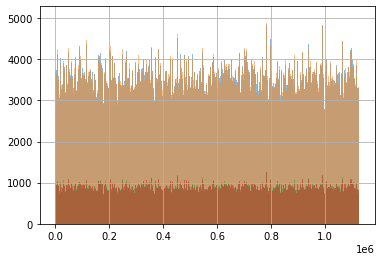

In [109]:
train_data.id_1.hist(alpha=0.5, bins=1000)
train_data.id_2.hist(alpha=0.5, bins=1000)

test_data.id_1.hist(alpha=0.5, bins=1000)
test_data.id_2.hist(alpha=0.5, bins=1000)

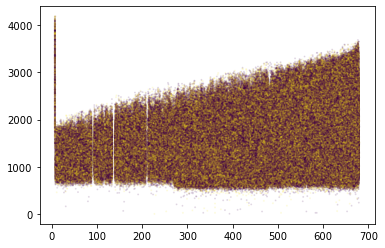

In [48]:
plt.scatter(train_data.game_duration, train_data.rating_1, s=1, c=train_data.target, alpha=0.1)

In [11]:
train_data[train_data.game_duration < 10].shape

(2236, 23)

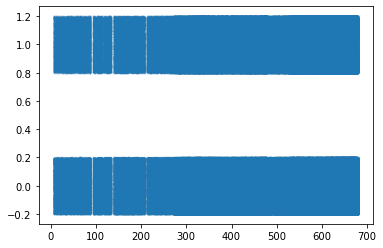

In [128]:
plt.scatter(train_data.game_duration, train_data.target+np.random.uniform(-0.2, 0.2, size=train_data['target'].shape), s=1,alpha=0.1)

In [31]:
train_data.target.mean()

0.38008287904916177

In [6]:
train_data.max()

game_mode              8
id_1             1126077
rating_1            4186
id_2             1126076
rating_2            4192
unit1_1              100
unit2_1              100
unit3_1              100
unit4_1              100
unit5_1              100
unit6_1              100
unit7_1              100
unit8_1              100
unit1_2              100
unit2_2              100
unit3_2              100
unit4_2              100
unit5_2              100
unit6_2              100
unit7_2              100
unit8_2              100
game_duration        680
target                 1
dtype: int64

In [7]:
sorted(test_data.game_mode.unique()), sorted(train_data.game_mode.unique())

([1, 2, 3, 4, 5, 6, 8], [1, 2, 3, 4, 5, 6, 8])

In [8]:
train_data['target'].shape

(3633005,)

-0.509434046041093
0.5560002114650253


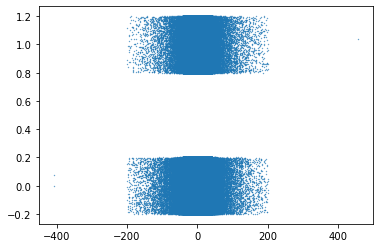

In [9]:
plt.scatter(train_data['rating_1']-train_data['rating_2'], train_data['target']+np.random.uniform(-0.2, 0.2, size=train_data['target'].shape),
           s=0.1)
print((train_data[train_data['target']==0]['rating_1']-train_data[train_data['target']==0]['rating_2']).mean())
print((train_data[train_data['target']==1]['rating_1']-train_data[train_data['target']==1]['rating_2']).mean())

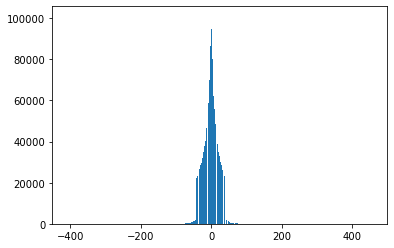

In [10]:
plt.hist(train_data['rating_1']-train_data['rating_2'], bins=1000)
None

In [11]:
train_data.corr()['target'].to_frame().T

,game_mode,id_1,rating_1,id_2,rating_2,unit1_1,unit2_1,unit3_1,unit4_1,unit5_1,...,unit1_2,unit2_2,unit3_2,unit4_2,unit5_2,unit6_2,unit7_2,unit8_2,game_duration,target
target,-0.000047,0.000439,0.000391,0.000194,-0.000675,-0.000384,-0.000087,0.000727,0.001189,-0.00026,...,-0.000682,-0.000494,-0.000642,-0.000863,-0.000194,0.000446,-0.000451,-0.000789,-0.000093,1.0


In [ ]:
train_data.

# OHE

In [62]:
pd.get_dummies(train_data.game_mode).add_prefix('game_mode_')

,game_mode_1,game_mode_2,game_mode_3,game_mode_4,game_mode_5,game_mode_6,game_mode_8
id,,,,,,,
0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
3633000,0,1,0,0,0,0,0
3633001,1,0,0,0,0,0,0
3633002,0,1,0,0,0,0,0


In [6]:
from sklearn.feature_extraction.text import CountVectorizer

0 100 101
0 100 101


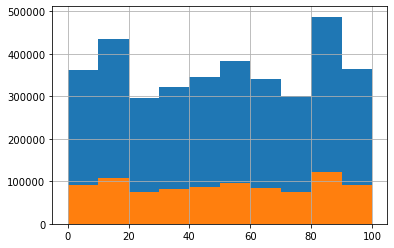

In [7]:
train_data.unit1_1.hist()
print(train_data.unit1_1.min(), train_data.unit1_1.max(), train_data.unit1_1.unique().size)

test_data.unit1_1.hist()
print(test_data.unit1_1.min(), test_data.unit1_1.max(), test_data.unit1_1.unique().size)

In [85]:
def make_unit_count(df, cols):
    cv = CountVectorizer(vocabulary=[str(i) for i in range(101)], token_pattern='\\d+')
    
    print('to str')
    stred = df.progress_apply(lambda x: ' '.join(map(str, x[cols].to_list())), axis=1)
    
    print('count vec')
    return cv.fit_transform(stred)

In [53]:
str_list[-1]

'100 26 80 94 92 18 64 57'

In [82]:
cv = CountVectorizer(vocabulary=[str(i) for i in range(101)], token_pattern='\\d+')

In [55]:
vectorized_1 = cv.fit_transform(str_list)

In [18]:
cols1 = [c for c in train_data.columns if 'unit' in c and '_1' in c]
cols2 = [c for c in train_data.columns if 'unit' in c and '_2' in c]

In [25]:
%%time
t=train_data[:10000].progress_apply(lambda x: (' '.join(map(str, x[cols1].to_list())), ' '.join(map(str, x[cols2].to_list()))), axis=1)

10000it [00:13, 747.95it/s]

CPU times: user 4.72 s, sys: 79.8 ms, total: 4.8 s
Wall time: 4.72 s


In [21]:
t

id
0       (71 79 53 89 15 1 75 80, 51 100 87 3 61 48 43 79)
1       (32 39 48 49 100 18 57 26, 39 83 91 6 57 94 15...
2       (43 21 58 94 88 93 16 61, 7 52 37 50 69 60 89 10)
3          (7 1 34 73 6 88 20 39, 39 27 55 97 83 1 88 87)
4       (53 35 16 80 72 81 43 42, 35 95 50 55 10 49 12...
                              ...                        
9995     (4 10 88 35 76 59 92 60, 19 70 79 45 26 1 24 94)
9996       (32 67 27 12 87 0 88 93, 6 60 7 39 52 1 89 10)
9997     (65 12 89 57 50 80 79 18, 50 55 86 10 0 30 16 8)
9998     (71 80 81 11 92 43 35 62, 1 2 37 12 61 90 88 30)
9999     (80 71 94 19 79 98 1 26, 74 23 16 76 27 8 55 10)
Length: 10000, dtype: object

In [86]:
%%time
train_vec_1 = make_unit_count(train_data, [c for c in train_data.columns if 'unit' in c and '_1' in c])

  0%|          | 838/3633005 [00:00<14:30, 4172.64it/s]

to str


100%|██████████| 3633005/3633005 [14:34<00:00, 4156.05it/s]


count vec
CPU times: user 14min 51s, sys: 12.5 s, total: 15min 3s
Wall time: 14min 48s


In [87]:
train_vec_2 = make_unit_count(train_data, [c for c in train_data.columns if 'unit' in c and '_2' in c])

  0%|          | 436/3633005 [00:00<13:53, 4359.20it/s]

to str


100%|██████████| 3633005/3633005 [14:31<00:00, 4168.02it/s]


count vec


In [88]:
scipy.sparse.save_npz("train_vec_1.npz", train_vec_1)

In [89]:
scipy.sparse.save_npz("train_vec_2.npz", train_vec_2)

In [90]:
test_vec_1 = make_unit_count(test_data, [c for c in test_data.columns if 'unit' in c and '_1' in c])
test_vec_2 = make_unit_count(test_data, [c for c in test_data.columns if 'unit' in c and '_2' in c])

scipy.sparse.save_npz("test_vec_1.npz", test_vec_1)
scipy.sparse.save_npz("test_vec_2.npz", test_vec_2)

  0%|          | 843/908252 [00:00<03:35, 4217.14it/s]

to str


100%|██████████| 908252/908252 [03:37<00:00, 4167.74it/s]


count vec


  0%|          | 811/908252 [00:00<03:39, 4135.80it/s]

to str


100%|██████████| 908252/908252 [03:37<00:00, 4183.89it/s]


count vec


In [61]:
train_data[-2:][[c for c in test_data.columns if 'unit' in c and '_1' in c]]

,unit1_1,unit2_1,unit3_1,unit4_1,unit5_1,unit6_1,unit7_1,unit8_1
id,,,,,,,,
3633003,10,31,47,68,94,93,32,82
3633004,80,43,7,37,1,61,60,52


In [103]:
test_vec_1.shape, test_vec_2.shape

((908252, 101), (908252, 101))

In [106]:
# check if units are unique between players
(test_vec_1.multiply(test_vec_2)).sum(), test_vec_1.sum(), test_vec_2.sum()

(1020539, 7266016, 7266016)

In [120]:
(train_vec_1.multiply(train_vec_2)).sum(), train_vec_1.sum(), train_vec_2.sum()

(4071668, 29064040, 29064040)

In [113]:
# turns out same units can indeed be picked by both sides
# let's find lines with same picks
pos = np.unravel_index(np.argmax(test_vec_1.multiply(test_vec_2)), test_vec_1.shape)
print(pos)
test_vec_1[pos[0]].todense(), test_vec_2[pos[0]].todense()

(93, 0)


(matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
          0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]]),
 matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
          0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]))

In [116]:
rows, cols = ((test_vec_1.multiply(test_vec_2))==1).nonzero()
rows, cols

(array([     0,      2,      3, ..., 908250, 908250, 908250], dtype=int32),
 array([80, 60,  1, ...,  0, 64, 79], dtype=int32))

In [121]:
rows_, cols_ = ((train_vec_1.multiply(train_vec_2))==1).nonzero()
rows_, cols_

(array([      0,       1,       1, ..., 3633003, 3633004, 3633004],
       dtype=int32),
 array([79, 39, 57, ..., 32,  7, 52], dtype=int32))

(array([ 83962., 135296.,  80346.,  73186., 120141.,  89720.,  96217.,
         93304., 166303.,  82064.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

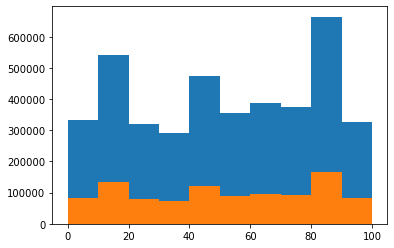

In [122]:
plt.hist(cols_)
plt.hist(cols)

In [129]:
train_data[[c for c in test_data.columns if 'unit' in c and '_1' in c]]

,unit1_1,unit2_1,unit3_1,unit4_1,unit5_1,unit6_1,unit7_1,unit8_1
id,,,,,,,,
0,71,79,53,89,15,1,75,80
1,32,39,48,49,100,18,57,26
2,43,21,58,94,88,93,16,61
3,7,1,34,73,6,88,20,39
4,53,35,16,80,72,81,43,42
...,...,...,...,...,...,...,...,...
3633000,24,65,54,86,9,5,92,15
3633001,26,50,81,33,8,16,34,79
3633002,48,64,55,3,31,18,80,35


In [124]:
t=pd.DataFrame.sparse.from_spmatrix(train_vec_1)
t

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
3,0,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3633000,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3633001,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3633002,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3633003,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [134]:
t['tar'] = train_data.target

In [137]:
cr = t.corr()
cr

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,tar
0,1.000000,-0.046600,-0.050879,-0.043521,0.002626,0.043905,-0.008427,-0.057258,-0.034051,-0.024452,...,0.049324,-0.023070,-0.053991,-0.053405,0.059357,-0.024626,-0.021827,0.009984,0.016286,0.000581
1,-0.046600,1.000000,0.112019,-0.098442,-0.022355,-0.125732,0.176315,0.339351,-0.074582,-0.043681,...,-0.124279,-0.076457,-0.012717,-0.092545,-0.127319,0.103088,0.023199,-0.035919,-0.059748,0.003339
2,-0.050879,0.112019,1.000000,-0.055800,0.005693,-0.055547,-0.002940,0.066373,-0.035652,-0.018771,...,-0.070679,0.014733,-0.025750,-0.055046,-0.045205,-0.023653,-0.014802,-0.028952,-0.015831,0.003588
3,-0.043521,-0.098442,-0.055800,1.000000,-0.025202,0.353084,-0.053078,-0.086696,-0.028097,-0.014442,...,0.223347,-0.034926,-0.031554,-0.081015,0.348460,-0.035517,-0.004038,-0.008474,-0.056078,-0.003037
4,0.002626,-0.022355,0.005693,-0.025202,1.000000,-0.028923,0.033680,-0.004006,-0.017874,0.022528,...,-0.028519,-0.022294,-0.028994,-0.018013,-0.030022,0.018509,0.000157,0.020600,-0.004459,-0.007109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,-0.024626,0.103088,-0.023653,-0.035517,0.018509,-0.040695,0.168005,-0.014776,-0.014408,-0.008776,...,-0.043683,-0.020546,-0.037660,-0.035963,-0.028500,1.000000,-0.019198,0.004192,-0.017355,-0.001703
98,-0.021827,0.023199,-0.014802,-0.004038,0.000157,-0.035593,-0.015206,-0.011356,-0.016747,0.000405,...,-0.066150,-0.021373,0.062739,0.022417,-0.031821,-0.019198,1.000000,-0.006229,-0.001710,-0.001834
99,0.009984,-0.035919,-0.028952,-0.008474,0.020600,0.022671,-0.014931,-0.029746,-0.017767,0.050158,...,-0.017800,-0.036681,-0.002173,-0.011016,-0.022173,0.004192,-0.006229,1.000000,-0.020421,-0.008032
100,0.016286,-0.059748,-0.015831,-0.056078,-0.004459,-0.085083,-0.071268,-0.081782,-0.067691,-0.029773,...,-0.093648,-0.021829,-0.059521,-0.061807,-0.095294,-0.017355,-0.001710,-0.020421,1.000000,0.002409


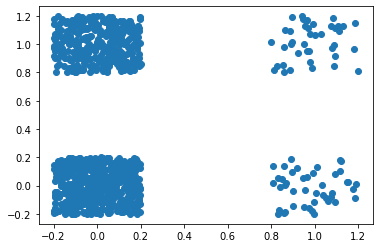

In [144]:
plt.scatter(t[:1000][0]+np.random.uniform(-0.2, 0.2, 1000), t[:1000]['tar']+np.random.uniform(-0.2, 0.2, 1000))

In [139]:
cr.tar.sort_values()

64    -0.015146
18    -0.011501
79    -0.011348
24    -0.011196
78    -0.010716
         ...   
53     0.007297
39     0.008082
7      0.008463
88     0.011200
tar    1.000000
Name: tar, Length: 102, dtype: float64

In [118]:
idx = 0
cols[idx], test_vec_1[rows[idx]].todense(), test_vec_2[rows[idx]].todense()

(80,
 matrix([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
          0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [37]:
type(train_vec_1)

scipy.sparse.csr.csr_matrix

In [53]:
train_vec_2[:10].todense()

matrix([[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

# add ohe to main

In [11]:
train_vec_1 = scipy.sparse.load_npz('./train_vec_1.npz')
train_vec_2 = scipy.sparse.load_npz('./train_vec_2.npz')
test_vec_1 = scipy.sparse.load_npz('./test_vec_1.npz')
test_vec_2 = scipy.sparse.load_npz('./test_vec_2.npz')

train_vec_1 = pd.DataFrame.sparse.from_spmatrix(train_vec_1).add_prefix('unit_').add_suffix('_1')
train_vec_2 = pd.DataFrame.sparse.from_spmatrix(train_vec_2).add_prefix('unit_').add_suffix('_2')
test_vec_1 = pd.DataFrame.sparse.from_spmatrix(test_vec_1).add_prefix('unit_').add_suffix('_1')
test_vec_2 = pd.DataFrame.sparse.from_spmatrix(test_vec_2).add_prefix('unit_').add_suffix('_2')

In [12]:
test_vec_1

,unit_0_1,unit_1_1,unit_2_1,unit_3_1,unit_4_1,unit_5_1,unit_6_1,unit_7_1,unit_8_1,unit_9_1,unit_10_1,unit_11_1,unit_12_1,unit_13_1,unit_14_1,unit_15_1,unit_16_1,unit_17_1,unit_18_1,unit_19_1,unit_20_1,unit_21_1,unit_22_1,unit_23_1,unit_24_1,unit_25_1,unit_26_1,unit_27_1,unit_28_1,unit_29_1,unit_30_1,unit_31_1,unit_32_1,unit_33_1,unit_34_1,unit_35_1,unit_36_1,unit_37_1,unit_38_1,unit_39_1,unit_40_1,unit_41_1,unit_42_1,unit_43_1,unit_44_1,unit_45_1,unit_46_1,unit_47_1,unit_48_1,unit_49_1,unit_50_1,unit_51_1,unit_52_1,unit_53_1,unit_54_1,unit_55_1,unit_56_1,unit_57_1,unit_58_1,unit_59_1,unit_60_1,unit_61_1,unit_62_1,unit_63_1,unit_64_1,unit_65_1,unit_66_1,unit_67_1,unit_68_1,unit_69_1,unit_70_1,unit_71_1,unit_72_1,unit_73_1,unit_74_1,unit_75_1,unit_76_1,unit_77_1,unit_78_1,unit_79_1,unit_80_1,unit_81_1,unit_82_1,unit_83_1,unit_84_1,unit_85_1,unit_86_1,unit_87_1,unit_88_1,unit_89_1,unit_90_1,unit_91_1,unit_92_1,unit_93_1,unit_94_1,unit_95_1,unit_96_1,unit_97_1,unit_98_1,unit_99_1,unit_100_1
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
908248,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
908249,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
908250,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
test_data_ = pd.concat((test_data, test_vec_1, test_vec_2, pd.get_dummies(test_data.game_mode).add_prefix('game_mode_')), axis=1)
train_data_ = pd.concat((train_data, train_vec_1, train_vec_2, pd.get_dummies(train_data.game_mode).add_prefix('game_mode_')), axis=1)

In [ ]:
cols = [c for c in train_data_.columns if c not in ['game_mode'] and ('unit' not in c or 'unit_' in c)]
cols

In [129]:
train_data_[cols]

,id_1,rating_1,id_2,rating_2,game_duration,target,unit_0_1,unit_1_1,unit_2_1,unit_3_1,...,unit_98_2,unit_99_2,unit_100_2,game_mode_1,game_mode_2,game_mode_3,game_mode_4,game_mode_5,game_mode_6,game_mode_8
0,908749,954,480270,935,329,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
1,438444,2162,486685,2154,581,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,596915,2066,711059,2081,548,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,625198,1508,66810,1474,555,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,228654,1202,542816,1196,651,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3633000,644871,1211,421763,1194,615,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3633001,689210,699,569184,706,517,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3633002,227914,1063,174332,1062,279,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3633003,1066558,1752,358523,1780,669,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


<AxesSubplot:>

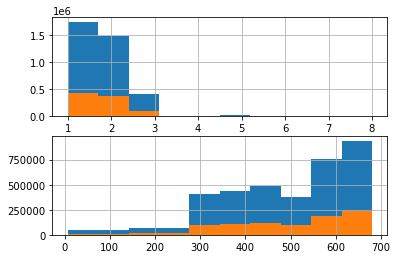

In [29]:
plt.subplot(211)
train_data.game_mode.hist()
test_data.game_mode.hist()

plt.subplot(212)
train_data.game_duration.hist()
test_data.game_duration.hist()

In [ ]:
# plid = 701511
for plid in df.T.sort_values('games_played', ascending=False).index[:10]:
    sel = train_data_[(train_data_.id_1 == plid)]
    print(sel[[c for c in cols if 'unit' in c and '_1' in c]].sum().values)

In [ ]:
# turns out people really enjoy their picks and tend to not change them

In [56]:
set([1,5, 4]) | set([4, 6,3])

{1, 3, 4, 5, 6}

In [107]:
from multiprocessing import Process, Manager, Pool

In [108]:
manager = Manager()
id_wrs = manager.dict()
def calc_wrs(player_id):
    flt = (train_data.id_1 == player_id)
    flt2 = (train_data.id_2 == player_id)

    fst = train_data[flt].target
    snd = 1 - train_data[flt2].target
    id_wrs[player_id] = {
        'first': fst.mean(),
        'second': snd.mean(),
        'overall': pd.concat((fst, snd)).mean(),
        'games_played': fst.size + snd.size,
        'was_first': fst.size / (fst.size + snd.size)
    }

In [89]:
# winrates when starting first, second and overall | 919435

with Pool(processes=8) as pool:
    for _ in tqdm.tqdm_notebook(pool.imap(calc_wrs, set(train_data.id_1.unique()) | set(train_data.id_2.unique()) )):
        pass
#     break

In [109]:
manager = Manager()
id_wrs = manager.dict()
def calc_wrs(player_id):
    flt = (test_data.id_1 == player_id)
    flt2 = (test_data.id_2 == player_id)

    fst = test_data[flt].rating_1
    snd = 1 - test_data[flt2].rating_1
    id_wrs[player_id] = {
        'games_played': fst.size + snd.size,
        'was_first': fst.size / (fst.size + snd.size)
    }

In [110]:
with Pool(processes=8) as pool:
    for _ in tqdm.tqdm_notebook(pool.imap(calc_wrs, set(test_data.id_1.unique()) | set(test_data.id_2.unique()) )):
        pass

In [111]:
df_test = pd.DataFrame().from_dict(dict(id_wrs)).T

In [113]:
df_test.to_csv('test_playtimes.csv')

(0.0, 50.0)

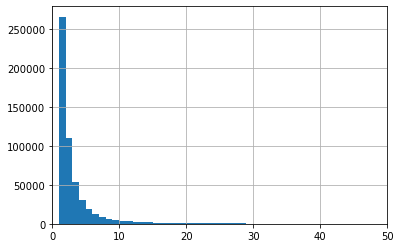

In [120]:
df_test.games_played.hist(bins=500)
plt.xlim(0, 50)

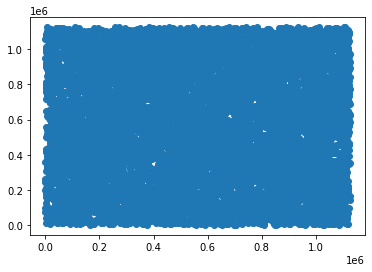

In [100]:
plt.scatter(train_data[:10000].id_1, train_data[:10000].id_2)

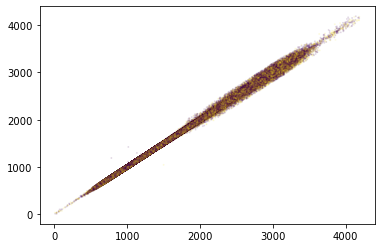

In [131]:
plt.scatter(train_data.rating_1, train_data.rating_2, c=train_data.target, s=1, alpha=0.1)

In [104]:
train_data[(train_data.id_1 == 713731) | (train_data.id_2 == 713731)]

,game_mode,id_1,rating_1,id_2,rating_2,unit1_1,unit2_1,unit3_1,unit4_1,unit5_1,...,unit1_2,unit2_2,unit3_2,unit4_2,unit5_2,unit6_2,unit7_2,unit8_2,game_duration,target
id,,,,,,,,,,,,,,,,,,,,,
1460,1,995021,1914,713731,1872,35,81,71,58,18,...,45,24,26,18,44,16,78,79,185,1
2199,1,551192,2157,713731,2168,24,67,10,37,19,...,16,24,18,79,26,44,78,45,574,0
2693,3,500948,2008,713731,2021,23,97,73,34,6,...,16,26,24,45,78,79,18,44,443,0
4106,2,136631,2287,713731,2295,59,88,58,17,12,...,79,45,24,26,44,16,18,78,647,0
7837,1,713731,2030,211362,2013,78,79,26,45,18,...,45,27,81,7,10,46,44,93,541,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3629785,2,352775,2076,713731,2060,43,84,94,31,88,...,26,45,18,24,16,44,78,79,666,0
3630132,1,46846,1895,713731,1941,82,2,89,94,69,...,16,45,24,44,18,26,79,78,262,0
3631579,1,713731,2018,475192,2013,45,78,26,16,24,...,44,45,81,16,93,27,10,60,523,1


<AxesSubplot:>

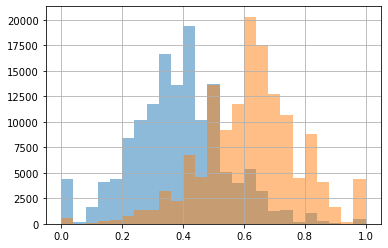

In [181]:
df.T[df.T.games_played > 10]['first'].hist(bins=25, alpha=0.5)
df.T[df.T.games_played > 10]['second'].hist(bins=25, alpha=0.5)

In [143]:
df.T.sort_values('games_played')

,first,second,overall,games_played,was_first
562750,NaN,1.000000,1.000000,1.0,0.000000
961295,NaN,1.000000,1.000000,1.0,0.000000
238806,NaN,1.000000,1.000000,1.0,0.000000
789200,1.000000,NaN,1.000000,1.0,1.000000
961296,0.000000,NaN,0.000000,1.0,1.000000
...,...,...,...,...,...
821312,0.382562,0.629699,0.502742,1094.0,0.513711
701511,0.413735,0.647154,0.532178,1212.0,0.492574
200103,0.386986,0.612083,0.503710,1213.0,0.481451
435112,0.411382,0.631751,0.521207,1226.0,0.501631


In [ ]:
# winrate asymmetry is clear

In [264]:
df.T[df.T.games_played <= 3].games_played.sum()

895168.0

In [263]:
df.T[df.T.games_played > 3].games_played.sum()

6370842.0

In [265]:
# most of the games are played by people from other games

In [ ]:
dct = dict(id_wrs)
dct

In [16]:
# df=pd.DataFrame().from_dict(dct)
df = pd.read_csv('winrates_trans.csv', index_col=0)

In [17]:
df

,first,second,overall,games_played,was_first
0,0.375000,0.444444,0.411765,17.0,0.470588
3,0.428571,0.833333,0.615385,13.0,0.538462
10,0.350000,0.576923,0.478261,46.0,0.434783
7,1.000000,NaN,1.000000,1.0,1.000000
9,NaN,0.500000,0.500000,2.0,0.000000
...,...,...,...,...,...
1126072,NaN,0.500000,0.500000,2.0,0.000000
1126071,0.000000,0.000000,0.000000,2.0,0.500000
1126077,0.000000,NaN,0.000000,1.0,1.000000
1126073,0.500000,0.620690,0.568627,51.0,0.431373


In [97]:
# df.to_csv('winrates.csv')

(0.0, 250.0)

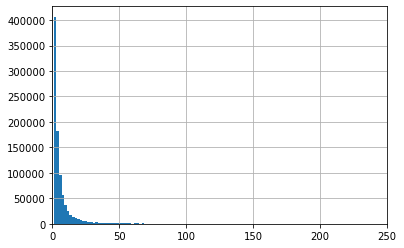

In [18]:
df.games_played.hist(bins=1000)
plt.xlim(0, 250)
# plt.ylim(0, 50000)

In [98]:
!ls -ali

итого 691205
265299 drwxrwxrwx 1 ayakovenko ayakovenko       432 июл 21 01:19 .
     5 drwxrwxrwx 1 ayakovenko ayakovenko      4096 июл 20 13:36 ..
265310 drwxrwxrwx 1 ayakovenko ayakovenko       184 июл 20 13:49 .ipynb_checkpoints
265308 -rwxrwxrwx 1 ayakovenko ayakovenko        42 июл 20 13:43 lauch_jup.sh
265309 -rwxrwxrwx 1 ayakovenko ayakovenko  30053267 июл 20 13:44 ngrok
265305 -rwxrwxrwx 1 ayakovenko ayakovenko        28 июл 20 13:43 open_to_network.sh
265300 -rwxrwxrwx 1 ayakovenko ayakovenko 164269437 июл 20 13:39 ozon-masters-ds-contest-2021.zip
265301 -rwxrwxrwx 1 ayakovenko ayakovenko  12504817 июл  6 09:03 sample_submission.csv
265302 -rwxrwxrwx 1 ayakovenko ayakovenko  76479150 июл  6 09:03 test.csv
265313 -rwxrwxrwx 1 ayakovenko ayakovenko   7089035 июл 20 22:49 test_vec_1.npz
265314 -rwxrwxrwx 1 ayakovenko ayakovenko   7070210 июл 20 22:49 test_vec_2.npz
265303 -rwxrwxrwx 1 ayakovenko ayakovenko 316137229 июл  6 09:03 train.csv
265320 -rwxrwxrwx 1 ayakovenko ayakovenko

In [60]:
id_wrs

{0: {'first': 0.375,
  'second': 0.4444444444444444,
  'overall': 0.4117647058823529,
  'games_played': 17,
  'was_first': 0.47058823529411764}}

In [122]:
len(set(train_data.id_1.unique()) | set(train_data.id_2.unique()))

919435

In [120]:
len((set(test_data.id_1.unique()) | set(test_data.id_2.unique())))

544807

In [118]:
len((set(train_data.id_1.unique()) | set(train_data.id_2.unique())) - (set(test_data.id_1.unique()) | set(test_data.id_2.unique())))

426142

# hero synergy / hero counters
inspired by dota2 papers  
lets introduce new features from this
paper: http://jmcauley.ucsd.edu/cse258/projects/fa15/018.pdf

In [197]:
synergy_1 = np.zeros((101, 101, 2))
for i in tqdm.tqdm_notebook(range(101)):
    for j in range(i, 101):
#         u1 = f"unit_{i}_1"
        flt = (train_data_[f"unit_{i}_1"] == 1) & (train_data_[f"unit_{j}_1"] == 1)
        wr = train_data_[flt]['target']
        synergy_1[i, j, 0] = wr.mean()
        synergy_1[i, j, 1] = wr.shape[0]
#         break
#     break

In [251]:
# np.save('synergy_1.npz', synergy_1)

In [195]:
train_data[flt]

,game_mode,id_1,rating_1,id_2,rating_2,unit1_1,unit2_1,unit3_1,unit4_1,unit5_1,unit6_1,unit7_1,unit8_1,unit1_2,unit2_2,unit3_2,unit4_2,unit5_2,unit6_2,unit7_2,unit8_2,game_duration,target
id,,,,,,,,,,,,,,,,,,,,,,,
6,1,549083,1165,855001,1149,5,14,79,24,54,0,45,10,92,18,64,70,26,43,65,35,605,1
7,2,657905,853,984324,847,54,35,94,0,64,79,24,10,29,53,92,0,49,94,48,63,321,0
20,2,645829,979,804615,987,95,64,80,51,45,79,0,32,24,70,10,80,82,19,43,94,319,0
30,2,387829,2214,637740,2228,26,80,89,100,32,0,43,44,10,80,32,12,20,94,79,82,624,0
34,1,885605,1753,664486,1739,92,0,88,76,62,43,80,81,53,100,57,93,1,88,37,25,522,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3632971,3,168399,895,1087783,934,1,0,44,10,60,16,79,24,79,70,10,15,5,60,94,48,478,0
3632972,2,81007,1432,36480,1421,35,81,49,0,86,80,48,53,33,1,83,94,15,26,91,79,662,1
3632985,3,318186,710,887226,707,20,54,75,26,30,24,96,0,80,37,14,32,7,48,52,1,448,0


In [207]:
synergy_1[0,0,0]

0.3809896678230053

In [206]:
np.unravel_index(synergy_1[...,0].argmax(), (101, 101))

(19, 72)

In [209]:
synergy_1[19,72,1]

17.0

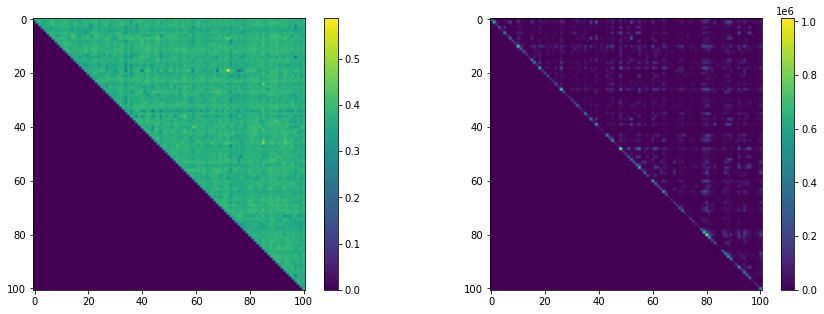

In [202]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(synergy_1[..., 0])
plt.colorbar()

plt.subplot(122)
plt.imshow(synergy_1[..., 1])
plt.colorbar()

In [17]:
synergy_2 = np.zeros((101, 101, 2))
for i in tqdm.tqdm_notebook(range(101)):
    for j in range(i, 101):
#         u1 = f"unit_{i}_1"
        flt = (train_data_[f"unit_{i}_2"] == 1) & (train_data_[f"unit_{j}_2"] == 1)
        wr = train_data_[flt]['target']
        synergy_2[i, j, 0] = wr.mean()
        synergy_2[i, j, 1] = wr.shape[0]

In [18]:
# np.save('synergy_2.npz', synergy_2)

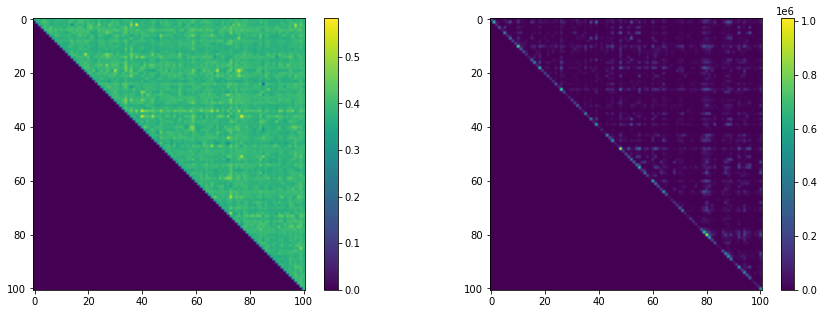

In [20]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(synergy_2[..., 0])
plt.colorbar()

plt.subplot(122)
plt.imshow(synergy_2[..., 1])
plt.colorbar()

In [254]:
counter_1 = np.zeros((101, 101, 2))
for i in tqdm.tqdm_notebook(range(101)):
    for j in range(0, 101):
#         u1 = f"unit_{i}_1"
        flt = (train_data_[f"unit_{i}_1"] == 1) & (train_data_[f"unit_{j}_2"] == 1)
        wr = train_data_[flt]['target']
        counter_1[i, j, 0] = wr.mean()
        counter_1[i, j, 1] = wr.shape[0]

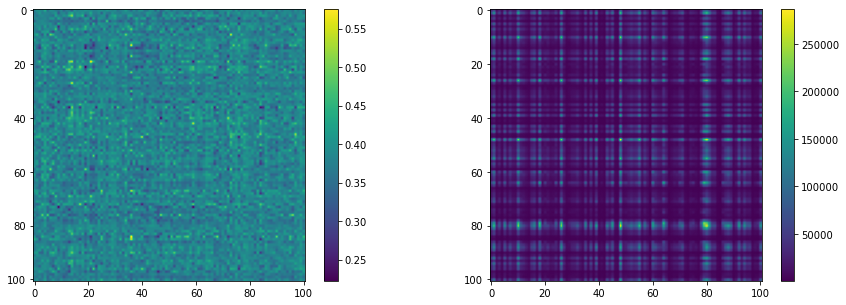

In [255]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(counter_1[..., 0])
plt.colorbar()

plt.subplot(122)
plt.imshow(counter_1[..., 1])
plt.colorbar()

In [256]:
# np.save('counter_1.npz', counter_1)

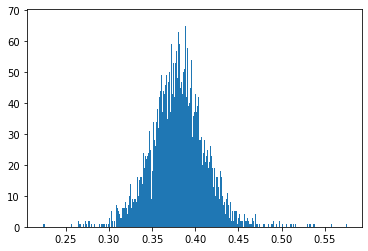

In [269]:
plt.hist(counter_1[..., 0].ravel(), bins=1000)
pass

In [21]:
synergy_1 = np.load('synergy_1.npz.npy')
synergy_2 = np.load('synergy_2.npz.npy')
counter_1 = np.load('counter_1.npz.npy')

In [24]:
# concated data is created in the next section :P
synergy_features = pd.DataFrame(index=sorted_concated_data.index,
                                columns=["wr_sum_1", "wr_sum_2", "synergy_1", "synergy_2", "countering"])

In [40]:
[print(i, j) for i in range(0,4) for j in range(i, 4)]

0 0
0 1
0 2
0 3
1 1
1 2
1 3
2 2
2 3
3 3


[None, None, None, None, None, None, None, None, None, None]

In [48]:
for i, (idx, row) in enumerate(tqdm.tqdm_notebook(sorted_concated_data.iterrows())):
    wr_1 = np.mean([synergy_1[int(row[f'unit{n}_1']), int(row[f'unit{n}_1']), 0] for n in range(1,9)])
    wr_2 = np.mean([synergy_2[int(row[f'unit{n}_2']), int(row[f'unit{n}_2']), 0] for n in range(1,9)])
    
    syn_1 = np.sum([synergy_1[int(row[f'unit{k}_1']), int(row[f'unit{l}_1']), 0] for k in range(1, 9) for l in range(k, 9)])
    syn_2 = np.sum([synergy_2[int(row[f'unit{k}_2']), int(row[f'unit{l}_2']), 0] for k in range(1, 9) for l in range(k, 9)])
    
    count = np.sum([synergy_2[int(row[f'unit{k}_1']), int(row[f'unit{l}_2']), 0] for k in range(1, 9) for l in range(1, 9)])
        
    synergy_features.iloc[i] = {
        "wr_sum_1": wr_1,
        "wr_sum_2": wr_2,
        "synergy_1": syn_1,
        "synergy_2": syn_2,
        "countering": count
    }
    
#     break

In [49]:
# synergy_features = synergy_features.infer_objects()
# synergy_features.to_csv('synergy_features.csv')

In [15]:
synergy_features = pd.read_csv('synergy_features.csv').set_index('id')

In [16]:
synergy_features

,wr_sum_1,wr_sum_2,synergy_1,synergy_2,countering
id,,,,,
1553,0.378493,0.374987,9.874406,7.838134,14.430872
3704,0.379328,0.372026,8.771386,9.162681,8.019371
5405,0.377649,0.372406,8.297881,10.673758,10.448882
5759,0.385276,0.383704,7.775452,4.624017,7.964928
5864,0.384726,0.373539,7.741946,8.850523,8.285142
...,...,...,...,...,...
3292774,0.378271,0.380173,9.359169,7.637745,13.863765
3328508,0.379341,0.380179,6.447660,6.500206,14.198070
3339136,0.380517,0.384494,6.558405,8.506247,13.031231


# rating
intuition says that after winning one's rating should go up  

In [80]:
plid = 435112
# plid = 992461
# plid = 821312
ratings = []
wins = []
durs = []
for pos, (line, row) in enumerate(train_data[(train_data.id_1 == plid) | (train_data.id_2 == plid)].iterrows()):
    if row.id_1 == plid:
        ratings.append(row.rating_1)
        wins.append(row.target)
    else:
        ratings.append(row.rating_2)
        wins.append(1 - row.target)
    
    durs.append(row.game_duration)

In [81]:
ratings = np.array(ratings)
wins = np.array(wins)
durs = np.array(durs)

In [82]:
plid = 435112
# plid = 992461 # some weird outliers in the beginning
# plid = 821312
ratings_ = []
wins_ = []
durs_ = []
for pos, (line, row) in enumerate(test_data[(test_data.id_1 == plid) | (test_data.id_2 == plid)].iterrows()):
    if row.id_1 == plid:
        ratings_.append(row.rating_1)
#         wins.append(row.target)
    else:
        ratings_.append(row.rating_2)
#         wins.append(1 - row.target)
    
    durs_.append(row.game_duration)
    
ratings_ = np.array(ratings_)
wins_ = np.array(wins_)
durs_ = np.array(durs_)

In [83]:
ratings[np.argsort(durs)]

array([1395, 1421, 1510, ..., 2933, 2727, 2729])

In [218]:
np.argsort(durs)

array([1797,   54,  983, ...,  681, 1190, 1356])

In [213]:
np.mean(wins)

0.5116279069767442

In [249]:
np.diff(ratings[np.argsort(durs)])[:20]

array([ 26,  89,  29,  54, -61,  30,   8, -33,  90,  28,  37, -33,  79,
        26, -55,  25,  58, -27, -35,  33])

In [250]:
wins[np.argsort(durs)][:20]

array([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1])

In [260]:
ratings[wins == 0].mean(), ratings[wins == 0].std(), ratings[wins == 1].mean(), ratings[wins == 1].std()

(2594.3321976149914, 300.84304663358427, 2559.2707355242565, 311.6369827513975)

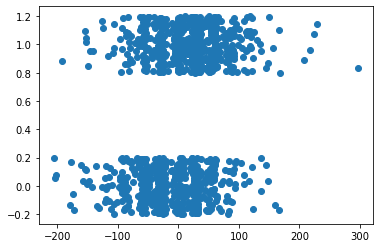

In [259]:
plt.scatter(np.diff(ratings[np.argsort(durs)]), wins[np.argsort(durs)][:-1]+np.random.uniform(-0.2, 0.2, size=wins[:-1].shape))

In [93]:
np.sort(durs)[:100]

array([ 18,  18,  20,  20,  20,  21,  21,  22,  22,  39,  40,  41,  41,
        44,  44,  44,  45,  45,  45,  46,  46,  46,  47,  61,  61,  69,
        70,  70,  70,  85,  85,  85,  85,  85,  86,  86,  86,  86,  86,
        94,  94,  95,  95,  95, 112, 112, 112, 112, 112, 113, 113, 132,
       132, 142, 142, 142, 143, 144, 144, 156, 156, 156, 156, 157, 157,
       157, 159, 159, 159, 159, 159, 159, 160, 160, 160, 160, 160, 160,
       160, 161, 165, 165, 165, 165, 165, 165, 166, 166, 166, 166, 167,
       183, 200, 200, 200, 200, 200, 200, 200, 201])

In [96]:
wins[np.argsort(durs)][:100]

array([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1])

In [97]:
ratings[np.argsort(durs)][:100]

array([1395, 1421, 1510, 1539, 1593, 1532, 1562, 1570, 1537, 1627, 1655,
       1692, 1659, 1738, 1764, 1709, 1734, 1792, 1765, 1730, 1763, 1762,
       1796, 1825, 1854, 1879, 1828, 1860, 1854, 1827, 1769, 1798, 1796,
       1768, 1738, 1730, 1763, 1764, 1733, 1962, 1933, 1935, 1872, 1905,
       1896, 1840, 1926, 1901, 1867, 1987, 1956, 1994, 1971, 2075, 2026,
       2056, 1996, 2050, 2016, 2086, 2051, 2120, 2153, 2098, 2127, 2096,
       2128, 2063, 2004, 2037, 2093, 2095, 2002, 2057, 2026, 2033, 1994,
       2054, 2023, 2081, 2132, 2105, 2076, 2102, 2133, 2050, 2164, 2172,
       2130, 2103, 2172, 2171, 2199, 2141, 2128, 2180, 2101, 2143, 2204,
       2155])

In [ ]:
for i in range(100):
    print(f"({wins[np.argsort(durs)][i]}, {ratings[np.argsort(durs)][i]}, {np.sort(durs)[i]})")

Text(0.5, 0, 'time')

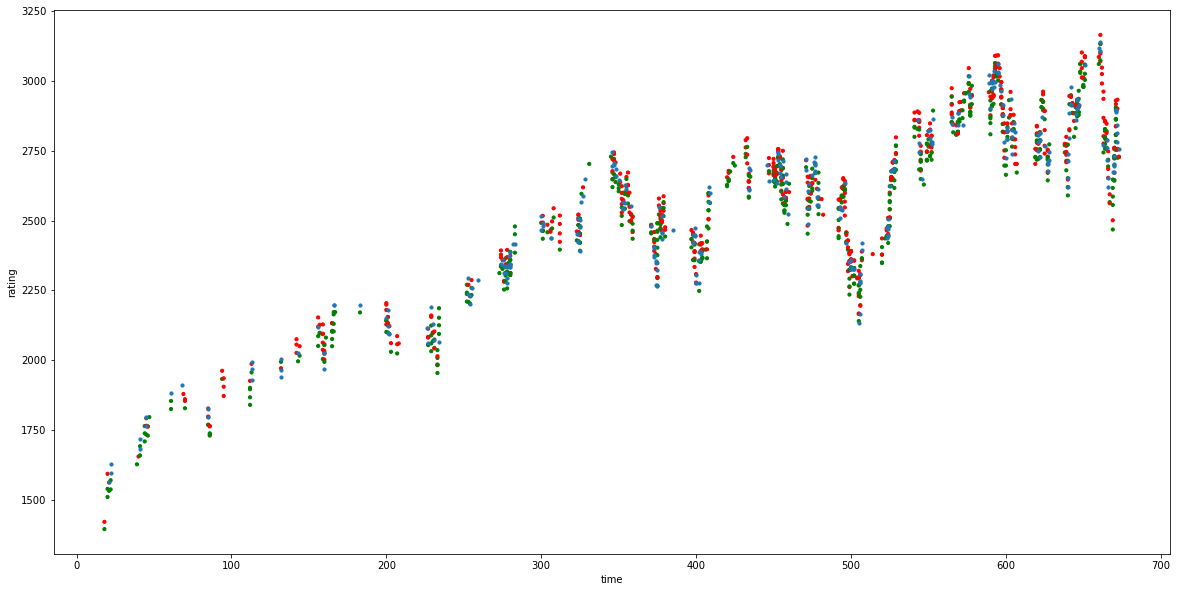

In [84]:
plt.figure(figsize=(20, 10))
plt.scatter(np.sort(durs), ratings[np.argsort(durs)], c=['green' if w else 'red' for w in wins[np.argsort(durs)]],s=10)
plt.scatter(np.sort(durs_), ratings_[np.argsort(durs_)],s=10)
# plt.xlim(0, 100)
plt.ylabel('rating')
plt.xlabel('time')

In [ ]:
# well, there it is
# looks like we've stumbled upon something big

(array([ 17.,  52., 123., 254., 331., 334., 338., 304., 149.,  33.]),
 array([1476. , 1574.8, 1673.6, 1772.4, 1871.2, 1970. , 2068.8, 2167.6,
        2266.4, 2365.2, 2464. ]),
 <BarContainer object of 10 artists>)

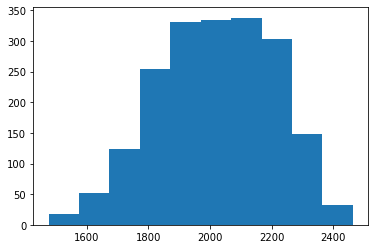

In [215]:
plt.hist(np.array(ratings))

In [45]:
sorted_train_data = train_data.sort_values('game_duration')
sorted_test_data = test_data.sort_values('game_duration')

In [19]:
concated_data = pd.concat((train_data, test_data))
sorted_concated_data = concated_data.sort_values(by=['game_duration', 'id'])

In [23]:
sorted_concated_data

,game_mode,id_1,rating_1,id_2,rating_2,unit1_1,unit2_1,unit3_1,unit4_1,unit5_1,unit6_1,unit7_1,unit8_1,unit1_2,unit2_2,unit3_2,unit4_2,unit5_2,unit6_2,unit7_2,unit8_2,game_duration,target
id,,,,,,,,,,,,,,,,,,,,,,,
1553,5,992461,3731,18188,3653,8,26,55,51,95,61,36,48,53,26,71,77,88,15,63,25,7,1.0
3704,5,1004577,3424,339146,3443,77,33,17,97,26,88,84,67,23,52,1,15,39,88,89,6,7,NaN
5405,8,811473,1454,141752,1428,61,51,8,48,36,26,95,58,1,7,52,32,89,39,37,88,7,NaN
5759,5,187297,3814,101185,3909,39,71,91,83,27,46,1,79,55,64,45,48,18,39,26,9,7,NaN
5864,8,702235,2775,899474,2757,62,76,23,88,12,27,26,55,52,7,41,11,45,10,33,69,7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3292774,2,151084,1209,645547,1190,24,91,35,27,26,100,74,60,96,44,5,86,87,60,46,49,680,0.0
3328508,2,373361,1887,1069124,1927,88,65,93,58,18,13,81,60,91,96,44,27,80,89,0,78,680,0.0
3339136,2,330379,1284,313438,1247,60,81,44,16,93,27,45,10,20,81,35,1,79,94,78,16,680,1.0


In [126]:
(test_data[test_data.id_1 == 1337]).shape

(0, 22)

In [ ]:
# calculate rating statistics for all days for each player
rating_stats = {}

for player_id in tqdm.tqdm_notebook(set(sorted_concated_data.id_1) | set(sorted_concated_data.id_2)):
    df_ = sorted_concated_data[(sorted_concated_data.id_1 == player_id) | (sorted_concated_data.id_2 == player_id)]
    df_1 = df_[df_.id_1 == player_id]
    df_2 = df_[df_.id_2 == player_id]
    days = df_.game_duration.unique()
    
    rt1 = df_1.rating_1.tolist()
    rt2 = df_2.rating_2.tolist()
    ratings = rt1 + rt2
    
    if not rt1:
        rt1 = [-1]
    if not rt2:
        rt2 = [-1]
    if not ratings:
        ratings = [-1]
    
    app = {
        "mean_rt_all": float(np.mean(ratings)),
        "std_rt_all": float(np.std(ratings)),
#         "mean_rt_all_1": float(np.mean(rt1)),
#         "std_rt_all_1": float(np.std(rt1)),
#         "mean_rt_all_2": float(np.mean(rt2)),
#         "std_rt_all_2": float(np.std(rt2))
    }
#     break
    for day in days:
        df_1_d = df_1[df_1.game_duration == day]
        df_2_d = df_2[df_2.game_duration == day]
        rt1 = df_1_d.rating_1.tolist()
        rt2 = df_2_d.rating_2.tolist()
        ratings = rt1 + rt2
        
        if not rt1:
            rt1 = [-1]
        if not rt2:
            rt2 = [-1]
        if not ratings:
            ratings = [-1]
        
        app.update({
            int(day): {
                "mean": float(np.mean(ratings)),
                "std": float(np.std(ratings)),
                "min": float(np.min(ratings)),
                "max": float(np.max(ratings)),
#                 "mean_1": float(np.mean(rt1)),
#                 "std_1": float(np.std(rt1)),
#                 "min_1": float(np.min(rt1)),
#                 "max_1": float(np.max(rt1)),
#                 "mean_2": float(np.mean(rt2)),
#                 "std_2": float(np.std(rt2)),
#                 "min_2": float(np.min(rt2)),
#                 "max_2": float(np.max(rt2))
            }
        })
        
    rating_stats[int(player_id)] = app
#     break

In [ ]:
with open('ratings.json', 'w') as f:
    json.dump(rating_stats, f)

In [12]:
rating_stats = {}
for rt_file in Path('.').glob('ratings_*.json'):
    with rt_file.open() as f:
        rating_stats.update(json.load(f))

In [21]:
rt_file

PosixPath('ratings_9.json')

In [38]:
type(next(iter(rating_stats.keys())))

str

In [ ]:
rating_stats

In [43]:
sorted(['10', '1', '200', '2', '35'], key=int)

['1', '2', '10', '35', '200']

In [49]:
['1', '2', '10', '35', '200'].index('200'), len(['1', '2', '10', '35', '200']), ['1', '2', '10', '35', '200'][4]

(4, 5, '200')

In [14]:
rating_features = pd.DataFrame(index=sorted_concated_data.index,
                               columns=["mn_rt_all_1", "std_rt_all_1", "mn_rt_td_1", "std_rt_td_1", "max_rt_td_1", 
                                        "min_rt_td_1", "mn_rt_tmr_1", "std_rt_tmr_1", "max_rt_tmr_1", "min_rt_tmr_1", "this_day_1", "next_day_1",
                                        "mn_rt_all_2", "std_rt_all_2", "mn_rt_td_2", "std_rt_td_2", "max_rt_td_2", 
                                        "min_rt_td_2", "mn_rt_tmr_2", "std_rt_tmr_2", "max_rt_tmr_2", "min_rt_tmr_2", "this_day_2", "next_day_2"])

In [57]:
pd.isna(rating_features.iloc[0,0])

True

In [21]:
for i, (idx, row) in enumerate(tqdm.tqdm_notebook(sorted_concated_data.iterrows())):
    day = row.game_duration
    rt_1 = row.rating_1
    rt_2 = row.rating_2
    dct = {}
    dct_1 = rating_stats.get(str(int(row.id_1)), None)
    dct_2 = rating_stats.get(str(int(row.id_2)), None)
    if dct_1:
        days_1 = sorted([d for d in dct_1 if d not in ['mean_rt_all', 'std_rt_all']], key=int)
        cur_idx_1 = days_1.index(str(int(day)))
        nxt_idx_1 = cur_idx_1 + 1 if cur_idx_1 + 1 != len(days_1) else cur_idx_1
        dct.update({
            "mn_rt_all_1": dct_1['mean_rt_all'],
            "std_rt_all_1": dct_1['std_rt_all'],
            "mn_rt_td_1": dct_1[days_1[cur_idx_1]]['mean'],
            "std_rt_td_1": dct_1[days_1[cur_idx_1]]['std'],
            "max_rt_td_1": dct_1[days_1[cur_idx_1]]['max'],
            "min_rt_td_1": dct_1[days_1[cur_idx_1]]['min'],
            "mn_rt_tmr_1": dct_1[days_1[nxt_idx_1]]['mean'],
            "std_rt_tmr_1": dct_1[days_1[nxt_idx_1]]['std'],
            "max_rt_tmr_1": dct_1[days_1[nxt_idx_1]]['max'],
            "min_rt_tmr_1": dct_1[days_1[nxt_idx_1]]['min'],
            "this_day_1": float(days_1[cur_idx_1]),
            "next_day_1": float(days_1[nxt_idx_1])
        })
    else:
        dct.update({
            "mn_rt_all_1": rt_1,
            "std_rt_all_1": 1000,
            "mn_rt_td_1": rt_1,
            "std_rt_td_1": 1000,
            "max_rt_td_1": rt_1,
            "min_rt_td_1": rt_1,
            "mn_rt_tmr_1": rt_1,
            "std_rt_tmr_1": 1000,
            "max_rt_tmr_1": rt_1,
            "min_rt_tmr_1": rt_1,
            "this_day_1": day,
            "next_day_1": day
        })
        
    if dct_2:
        days_2 = sorted([d for d in dct_2 if d not in ['mean_rt_all', 'std_rt_all']], key=int)
        cur_idx_2 = days_2.index(str(int(day)))
        nxt_idx_2 = cur_idx_2 + 1 if cur_idx_2 + 1 != len(days_2) else cur_idx_2
        dct.update({
            "mn_rt_all_2": dct_2['mean_rt_all'],
            "std_rt_all_2": dct_2['std_rt_all'],
            "mn_rt_td_2": dct_2[days_2[cur_idx_2]]['mean'],
            "std_rt_td_2": dct_2[days_2[cur_idx_2]]['std'],
            "max_rt_td_2": dct_2[days_2[cur_idx_2]]['max'],
            "min_rt_td_2": dct_2[days_2[cur_idx_2]]['min'],
            "mn_rt_tmr_2": dct_2[days_2[nxt_idx_2]]['mean'],
            "std_rt_tmr_2": dct_2[days_2[nxt_idx_2]]['std'],
            "max_rt_tmr_2": dct_2[days_2[nxt_idx_2]]['max'],
            "min_rt_tmr_2": dct_2[days_2[nxt_idx_2]]['min'],
            "this_day_2": float(days_2[cur_idx_2]),
            "next_day_2": float(days_2[nxt_idx_2])
        })
    else:
        dct.update({
            "mn_rt_all_2": rt_2,
            "std_rt_all_2": 1000,
            "mn_rt_td_2": rt_2,
            "std_rt_td_2": 1000,
            "max_rt_td_2": rt_2,
            "min_rt_td_2": rt_2,
            "mn_rt_tmr_2": rt_2,
            "std_rt_tmr_2": 1000,
            "max_rt_tmr_2": rt_2,
            "min_rt_tmr_2": rt_2,
            "this_day_2": day,
            "next_day_2": day
        })
        
    rating_features.iloc[i] = dct
    
#     break

In [26]:
rating_features = rating_features.infer_objects()

In [29]:
rating_features

,mn_rt_all_1,std_rt_all_1,mn_rt_td_1,std_rt_td_1,max_rt_td_1,min_rt_td_1,mn_rt_tmr_1,std_rt_tmr_1,max_rt_tmr_1,min_rt_tmr_1,this_day_1,next_day_1,mn_rt_all_2,std_rt_all_2,mn_rt_td_2,std_rt_td_2,max_rt_td_2,min_rt_td_2,mn_rt_tmr_2,std_rt_tmr_2,max_rt_tmr_2,min_rt_tmr_2,this_day_2,next_day_2
id,,,,,,,,,,,,,,,,,,,,,,,,
1553,3027.820513,245.411594,3733.142857,50.484590,3814.0,3664.0,1830.0,0.0,1830.0,1830.0,7.0,433.0,2861.664804,291.598062,3685.666667,25.090946,3714.0,3653.0,1738.0,0.0,1738.0,1738.0,7.0,27.0
3704,2850.098291,387.650168,3378.666667,33.289972,3424.0,3345.0,1796.0,0.0,1796.0,1796.0,7.0,12.0,2620.487179,403.336144,3462.000000,20.581545,3504.0,3440.0,1770.0,64.0,1834.0,1706.0,7.0,107.0
5405,1454.000000,0.000000,1454.000000,0.000000,1454.0,1454.0,1454.0,0.0,1454.0,1454.0,7.0,7.0,776.333333,238.635752,1428.000000,0.000000,1428.0,1428.0,730.0,0.0,730.0,730.0,7.0,13.0
5759,2334.421801,339.565651,3827.666667,32.499573,3878.0,3779.0,1816.5,17.5,1834.0,1799.0,7.0,18.0,2831.035599,370.179378,3875.222222,20.627801,3909.0,3848.0,1827.0,0.0,1827.0,1827.0,7.0,19.0
5864,1987.476378,270.293864,2703.875000,49.533921,2775.0,2629.0,2784.0,0.0,2784.0,2784.0,7.0,8.0,1981.855422,191.653498,2757.000000,0.000000,2757.0,2757.0,1477.0,0.0,1477.0,1477.0,7.0,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3292774,1312.363636,114.594521,1209.000000,0.000000,1209.0,1209.0,1209.0,0.0,1209.0,1209.0,680.0,680.0,1190.000000,0.000000,1190.000000,0.000000,1190.0,1190.0,1190.0,0.0,1190.0,1190.0,680.0,680.0
3328508,1539.400000,176.236886,1887.000000,0.000000,1887.0,1887.0,1887.0,0.0,1887.0,1887.0,680.0,680.0,1793.854839,182.465538,1927.000000,0.000000,1927.0,1927.0,1927.0,0.0,1927.0,1927.0,680.0,680.0
3339136,1435.346154,124.309150,1284.000000,0.000000,1284.0,1284.0,1284.0,0.0,1284.0,1284.0,680.0,680.0,1363.571429,109.724469,1247.000000,0.000000,1247.0,1247.0,1247.0,0.0,1247.0,1247.0,680.0,680.0


In [28]:
# rating_features.to_csv('rating_features.csv')

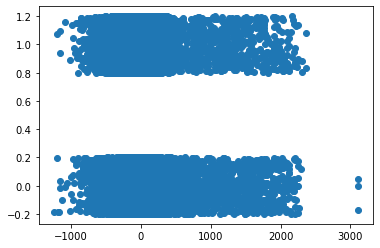

In [33]:
plt.scatter(rating_features['mn_rt_td_1'] - rating_features['mn_rt_tmr_1'], sorted_concated_data['target']+np.random.uniform(-0.2, 0.2, size=sorted_concated_data['target'].shape))

In [73]:
sorted_concated_data[(sorted_concated_data.id_1 == 992461) | (sorted_concated_data.id_2 == 992461)][:30]

,game_mode,id_1,rating_1,id_2,rating_2,unit1_1,unit2_1,unit3_1,unit4_1,unit5_1,unit6_1,unit7_1,unit8_1,unit1_2,unit2_2,unit3_2,unit4_2,unit5_2,unit6_2,unit7_2,unit8_2,game_duration,target
id,,,,,,,,,,,,,,,,,,,,,,,
1553,5,992461,3731,18188,3653,8,26,55,51,95,61,36,48,53,26,71,77,88,15,63,25,7,1.0
88840,5,992461,3690,341352,3728,61,95,36,8,51,26,55,48,94,91,15,39,46,71,1,88,7,NaN
1192510,5,907310,3782,992461,3785,1,88,27,55,97,83,87,39,8,48,26,55,95,36,51,61,7,0.0
1308885,5,948267,3788,992461,3694,32,44,0,26,80,43,100,89,48,51,26,55,36,95,61,8,7,0.0
2421989,5,807564,3777,992461,3754,25,71,53,35,87,100,88,93,55,61,51,48,8,36,95,26,7,0.0
2718362,5,992461,3664,953213,3672,95,26,48,61,8,51,55,36,92,80,71,35,81,43,11,0,7,1.0
3574071,5,992461,3814,101185,3883,36,55,48,51,26,61,95,8,26,64,45,18,48,9,55,39,7,1.0
3398711,1,143948,1794,992461,1830,55,21,72,26,81,62,43,48,13,48,76,55,62,61,65,39,433,0.0
2416900,1,357035,2282,992461,2302,60,6,88,39,7,52,15,1,61,85,55,36,8,26,95,48,436,1.0


In [17]:
rating_features = pd.read_csv('rating_features.csv').set_index('id')

# models and training

In [20]:
train_merge = pd.merge(train_data_, rating_features[sorted_concated_data.target.notna()], 'left', left_index=True, right_index=True)
train_merge = pd.merge(train_merge, synergy_features[sorted_concated_data.target.notna()], 'left', left_index=True, right_index=True)

In [21]:
test_merge = pd.merge(test_data_, rating_features[~sorted_concated_data.target.notna()], 'left', left_index=True, right_index=True)
test_merge = pd.merge(test_merge, synergy_features[~sorted_concated_data.target.notna()], 'left', left_index=True, right_index=True)

In [14]:
train_merge.info(), test_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3633005 entries, 0 to 3633004
Columns: 298 entries, game_mode to rating_max_tmr_diff_21
dtypes: float32(298)
memory usage: 4.1 GB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 908252 entries, 0 to 908251
Columns: 260 entries, game_mode to countering
dtypes: float32(260)
memory usage: 907.8 MB


(None, None)

In [25]:
# train_merge.to_csv('train_merge.csv', chunksize=100000)

In [27]:
# test_merge.to_csv('test_merge.csv', chunksize=100000)

In [7]:
train_merge = pd.read_csv('train_merge.csv').set_index('Unnamed: 0').astype(np.float32)
test_merge = pd.read_csv('test_merge.csv').set_index('Unnamed: 0').astype(np.float32)

In [8]:
# ============================
# combined features
# ============================

# dates
train_merge['days_between_games_1'] = train_merge['this_day_1'] - train_merge['next_day_1']
train_merge['days_between_games_2'] = train_merge['this_day_2'] - train_merge['next_day_2']

# hero picks
train_merge['synergy_diff'] = train_merge['synergy_1'] - train_merge['synergy_2']
train_merge['synergy_countering_diff_1'] = train_merge['synergy_1'] - train_merge['countering']
train_merge['synergy_countering_diff_2'] = train_merge['synergy_2'] - train_merge['countering']
train_merge['wr_sum_diff'] = train_merge['wr_sum_1'] - train_merge['wr_sum_2']

# rating
train_merge['rating_diff'] = train_merge['rating_1'] - train_merge['rating_2']
train_merge['rating_mean_diff'] = train_merge['mn_rt_all_1'] - train_merge['mn_rt_all_2']
train_merge['rating_std_diff'] = train_merge['std_rt_all_1'] - train_merge['std_rt_all_2']

train_merge['rating_mean_all_diff_1'] = train_merge['mn_rt_all_1'] - train_merge['rating_1']
train_merge['rating_mean_td_diff_1'] = train_merge['mn_rt_td_1'] - train_merge['rating_1']
train_merge['rating_mean_tmr_diff_1'] = train_merge['mn_rt_tmr_1'] - train_merge['rating_1']
train_merge['rating_min_td_diff_1'] = train_merge['min_rt_td_1'] - train_merge['rating_1']
train_merge['rating_min_tmr_diff_1'] = train_merge['min_rt_tmr_1'] - train_merge['rating_1']
train_merge['rating_max_td_diff_1'] = train_merge['max_rt_td_1'] - train_merge['rating_1']
train_merge['rating_max_tmr_diff_1'] = train_merge['max_rt_tmr_1'] - train_merge['rating_1']

train_merge['rating_mean_all_diff_2'] = train_merge['mn_rt_all_2'] - train_merge['rating_2']
train_merge['rating_mean_td_diff_2'] = train_merge['mn_rt_td_2'] - train_merge['rating_2']
train_merge['rating_mean_tmr_diff_2'] = train_merge['mn_rt_tmr_2'] - train_merge['rating_2']
train_merge['rating_min_td_diff_2'] = train_merge['min_rt_td_2'] - train_merge['rating_2']
train_merge['rating_min_tmr_diff_2'] = train_merge['min_rt_tmr_2'] - train_merge['rating_2']
train_merge['rating_max_td_diff_2'] = train_merge['max_rt_td_2'] - train_merge['rating_2']
train_merge['rating_max_tmr_diff_2'] = train_merge['max_rt_tmr_2'] - train_merge['rating_2']

train_merge['rating_mean_all_diff_12'] = train_merge['mn_rt_all_1'] - train_merge['rating_2']
train_merge['rating_mean_td_diff_12'] = train_merge['mn_rt_td_1'] - train_merge['rating_2']
train_merge['rating_mean_tmr_diff_12'] = train_merge['mn_rt_tmr_1'] - train_merge['rating_2']
train_merge['rating_min_td_diff_12'] = train_merge['min_rt_td_1'] - train_merge['rating_2']
train_merge['rating_min_tmr_diff_12'] = train_merge['min_rt_tmr_1'] - train_merge['rating_2']
train_merge['rating_max_td_diff_12'] = train_merge['max_rt_td_1'] - train_merge['rating_2']
train_merge['rating_max_tmr_diff_12'] = train_merge['max_rt_tmr_1'] - train_merge['rating_2']

train_merge['rating_mean_all_diff_21'] = train_merge['mn_rt_all_2'] - train_merge['rating_1']
train_merge['rating_mean_td_diff_21'] = train_merge['mn_rt_td_2'] - train_merge['rating_1']
train_merge['rating_mean_tmr_diff_21'] = train_merge['mn_rt_tmr_2'] - train_merge['rating_1']
train_merge['rating_min_td_diff_21'] = train_merge['min_rt_td_2'] - train_merge['rating_1']
train_merge['rating_min_tmr_diff_21'] = train_merge['min_rt_tmr_2'] - train_merge['rating_1']
train_merge['rating_max_td_diff_21'] = train_merge['max_rt_td_2'] - train_merge['rating_1']
train_merge['rating_max_tmr_diff_21'] = train_merge['max_rt_tmr_2'] - train_merge['rating_1']

In [9]:
# ============================
# combined features
# ============================

# dates
test_merge['days_between_games_1'] = test_merge['this_day_1'] - test_merge['next_day_1']
test_merge['days_between_games_2'] = test_merge['this_day_2'] - test_merge['next_day_2']

# hero picks
test_merge['synergy_diff'] = test_merge['synergy_1'] - test_merge['synergy_2']
test_merge['synergy_countering_diff_1'] = test_merge['synergy_1'] - test_merge['countering']
test_merge['synergy_countering_diff_2'] = test_merge['synergy_2'] - test_merge['countering']
test_merge['wr_sum_diff'] = test_merge['wr_sum_1'] - test_merge['wr_sum_2']

# rating
test_merge['rating_diff'] = test_merge['rating_1'] - test_merge['rating_2']
test_merge['rating_mean_diff'] = test_merge['mn_rt_all_1'] - test_merge['mn_rt_all_2']
test_merge['rating_std_diff'] = test_merge['std_rt_all_1'] - test_merge['std_rt_all_2']

test_merge['rating_mean_all_diff_1'] = test_merge['mn_rt_all_1'] - test_merge['rating_1']
test_merge['rating_mean_td_diff_1'] = test_merge['mn_rt_td_1'] - test_merge['rating_1']
test_merge['rating_mean_tmr_diff_1'] = test_merge['mn_rt_tmr_1'] - test_merge['rating_1']
test_merge['rating_min_td_diff_1'] = test_merge['min_rt_td_1'] - test_merge['rating_1']
test_merge['rating_min_tmr_diff_1'] = test_merge['min_rt_tmr_1'] - test_merge['rating_1']
test_merge['rating_max_td_diff_1'] = test_merge['max_rt_td_1'] - test_merge['rating_1']
test_merge['rating_max_tmr_diff_1'] = test_merge['max_rt_tmr_1'] - test_merge['rating_1']

test_merge['rating_mean_all_diff_2'] = test_merge['mn_rt_all_2'] - test_merge['rating_2']
test_merge['rating_mean_td_diff_2'] = test_merge['mn_rt_td_2'] - test_merge['rating_2']
test_merge['rating_mean_tmr_diff_2'] = test_merge['mn_rt_tmr_2'] - test_merge['rating_2']
test_merge['rating_min_td_diff_2'] = test_merge['min_rt_td_2'] - test_merge['rating_2']
test_merge['rating_min_tmr_diff_2'] = test_merge['min_rt_tmr_2'] - test_merge['rating_2']
test_merge['rating_max_td_diff_2'] = test_merge['max_rt_td_2'] - test_merge['rating_2']
test_merge['rating_max_tmr_diff_2'] = test_merge['max_rt_tmr_2'] - test_merge['rating_2']

test_merge['rating_mean_all_diff_12'] = test_merge['mn_rt_all_1'] - test_merge['rating_2']
test_merge['rating_mean_td_diff_12'] = test_merge['mn_rt_td_1'] - test_merge['rating_2']
test_merge['rating_mean_tmr_diff_12'] = test_merge['mn_rt_tmr_1'] - test_merge['rating_2']
test_merge['rating_min_td_diff_12'] = test_merge['min_rt_td_1'] - test_merge['rating_2']
test_merge['rating_min_tmr_diff_12'] = test_merge['min_rt_tmr_1'] - test_merge['rating_2']
test_merge['rating_max_td_diff_12'] = test_merge['max_rt_td_1'] - test_merge['rating_2']
test_merge['rating_max_tmr_diff_12'] = test_merge['max_rt_tmr_1'] - test_merge['rating_2']

test_merge['rating_mean_all_diff_21'] = test_merge['mn_rt_all_2'] - test_merge['rating_1']
test_merge['rating_mean_td_diff_21'] = test_merge['mn_rt_td_2'] - test_merge['rating_1']
test_merge['rating_mean_tmr_diff_21'] = test_merge['mn_rt_tmr_2'] - test_merge['rating_1']
test_merge['rating_min_td_diff_21'] = test_merge['min_rt_td_2'] - test_merge['rating_1']
test_merge['rating_min_tmr_diff_21'] = test_merge['min_rt_tmr_2'] - test_merge['rating_1']
test_merge['rating_max_td_diff_21'] = test_merge['max_rt_td_2'] - test_merge['rating_1']
test_merge['rating_max_tmr_diff_21'] = test_merge['max_rt_tmr_2'] - test_merge['rating_1']

In [ ]:
cols = [c for c in train_merge.columns if c not in ['game_mode', 'id_1', 'id_2', 'target'] and ('unit' not in c or 'unit_' in c)]
cols

(3633005, 261)

In [17]:
train_merge[cols]

,rating_1,rating_2,game_duration,unit_0_1,unit_1_1,unit_2_1,unit_3_1,unit_4_1,unit_5_1,unit_6_1,unit_7_1,unit_8_1,unit_9_1,unit_10_1,unit_11_1,unit_12_1,unit_13_1,unit_14_1,unit_15_1,unit_16_1,unit_17_1,unit_18_1,unit_19_1,unit_20_1,unit_21_1,unit_22_1,unit_23_1,unit_24_1,unit_25_1,unit_26_1,unit_27_1,unit_28_1,unit_29_1,unit_30_1,unit_31_1,unit_32_1,unit_33_1,unit_34_1,unit_35_1,unit_36_1,unit_37_1,unit_38_1,unit_39_1,unit_40_1,unit_41_1,unit_42_1,unit_43_1,unit_44_1,unit_45_1,unit_46_1,unit_47_1,unit_48_1,unit_49_1,unit_50_1,unit_51_1,unit_52_1,unit_53_1,unit_54_1,unit_55_1,unit_56_1,unit_57_1,unit_58_1,unit_59_1,unit_60_1,unit_61_1,unit_62_1,unit_63_1,unit_64_1,unit_65_1,unit_66_1,unit_67_1,unit_68_1,unit_69_1,unit_70_1,unit_71_1,unit_72_1,unit_73_1,unit_74_1,unit_75_1,unit_76_1,unit_77_1,unit_78_1,unit_79_1,unit_80_1,unit_81_1,unit_82_1,unit_83_1,unit_84_1,unit_85_1,unit_86_1,unit_87_1,unit_88_1,unit_89_1,unit_90_1,unit_91_1,unit_92_1,unit_93_1,unit_94_1,unit_95_1,unit_96_1,unit_97_1,unit_98_1,unit_99_1,unit_100_1,unit_0_2,unit_1_2,unit_2_2,unit_3_2,unit_4_2,unit_5_2,unit_6_2,unit_7_2,unit_8_2,unit_9_2,unit_10_2,unit_11_2,unit_12_2,unit_13_2,unit_14_2,unit_15_2,unit_16_2,unit_17_2,unit_18_2,unit_19_2,unit_20_2,unit_21_2,unit_22_2,unit_23_2,unit_24_2,unit_25_2,unit_26_2,unit_27_2,unit_28_2,unit_29_2,unit_30_2,unit_31_2,unit_32_2,unit_33_2,unit_34_2,unit_35_2,unit_36_2,unit_37_2,unit_38_2,unit_39_2,unit_40_2,unit_41_2,unit_42_2,unit_43_2,unit_44_2,unit_45_2,unit_46_2,unit_47_2,unit_48_2,unit_49_2,unit_50_2,unit_51_2,unit_52_2,unit_53_2,unit_54_2,unit_55_2,unit_56_2,unit_57_2,unit_58_2,unit_59_2,unit_60_2,unit_61_2,unit_62_2,unit_63_2,unit_64_2,unit_65_2,unit_66_2,unit_67_2,unit_68_2,unit_69_2,unit_70_2,unit_71_2,unit_72_2,unit_73_2,unit_74_2,unit_75_2,unit_76_2,unit_77_2,unit_78_2,unit_79_2,unit_80_2,unit_81_2,unit_82_2,unit_83_2,unit_84_2,unit_85_2,unit_86_2,unit_87_2,unit_88_2,unit_89_2,unit_90_2,unit_91_2,unit_92_2,unit_93_2,unit_94_2,unit_95_2,unit_96_2,unit_97_2,unit_98_2,unit_99_2,unit_100_2,game_mode_1,game_mode_2,game_mode_3,game_mode_4,game_mode_5,game_mode_6,game_mode_8,mn_rt_all_1,std_rt_all_1,mn_rt_td_1,std_rt_td_1,max_rt_td_1,min_rt_td_1,mn_rt_tmr_1,std_rt_tmr_1,max_rt_tmr_1,min_rt_tmr_1,this_day_1,next_day_1,mn_rt_all_2,std_rt_all_2,mn_rt_td_2,std_rt_td_2,max_rt_td_2,min_rt_td_2,mn_rt_tmr_2,std_rt_tmr_2,max_rt_tmr_2,min_rt_tmr_2,this_day_2,next_day_2,wr_sum_1,wr_sum_2,synergy_1,synergy_2,countering,days_between_games_1,days_between_games_2,synergy_diff,synergy_countering_diff_1,synergy_countering_diff_2,wr_sum_diff,rating_diff,rating_mean_diff,rating_std_diff,rating_mean_all_diff_1,rating_mean_td_diff_1,rating_mean_tmr_diff_1,rating_min_td_diff_1,rating_min_tmr_diff_1,rating_max_td_diff_1,rating_max_tmr_diff_1,rating_mean_all_diff_2,rating_mean_td_diff_2,rating_mean_tmr_diff_2,rating_min_td_diff_2,rating_min_tmr_diff_2,rating_max_td_diff_2,rating_max_tmr_diff_2,rating_mean_all_diff_12,rating_mean_td_diff_12,rating_mean_tmr_diff_12,rating_min_td_diff_12,rating_min_tmr_diff_12,rating_max_td_diff_12,rating_max_tmr_diff_12,rating_mean_all_diff_21,rating_mean_td_diff_21,rating_mean_tmr_diff_21,rating_min_td_diff_21,rating_min_tmr_diff_21,rating_max_td_diff_21,rating_max_tmr_diff_21
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,954.0,935.0,329.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0

In [11]:
from catboost import CatBoostClassifier, Pool, cv

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train_merge[cols], train_merge.target, test_size=0.05, random_state=42, stratify=train_merge.target)

In [14]:
model = CatBoostClassifier(iterations=10000, task_type='GPU', loss_function='Logloss')

In [ ]:
model.fit(X_train, y_train, verbose=True)

In [16]:
pred = model.predict_proba(X_test)

In [17]:
pred[:,1]

array([0.64286263, 0.81358506, 0.37615927, ..., 0.00683124, 0.94665678,
       0.09430552])

In [18]:
log_loss(y_test, pred[:, 1])

0.4358140934060772

In [22]:
y_test

Unnamed: 0
337654     1.0
3352376    1.0
866252     0.0
270628     0.0
2177150    1.0
          ... 
608491     0.0
1387573    1.0
3529318    0.0
2403167    1.0
2103555    0.0
Name: target, Length: 181651, dtype: float32

<BarContainer object of 278 artists>

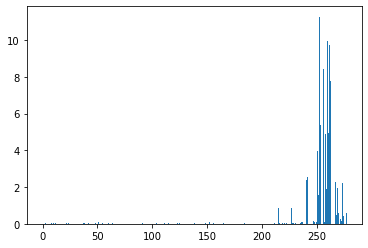

In [19]:
plt.bar(range(len(model.feature_importances_)),model.feature_importances_)

In [22]:
ft_i = pd.DataFrame().from_dict({'f_name': train_merge[cols].columns, 'importance': model.feature_importances_})

In [28]:
ft_i.sort_values('importance', ascending=False).head(60)

,f_name,importance
253,rating_min_td_diff_1,11.265824
260,rating_min_td_diff_2,9.925867
255,rating_max_td_diff_1,9.751740
262,rating_max_td_diff_2,9.716239
256,rating_max_tmr_diff_1,8.410807
263,rating_max_tmr_diff_2,7.778035
254,rating_min_tmr_diff_1,5.357677
261,rating_min_tmr_diff_2,4.934654
258,rating_mean_td_diff_2,4.862163
251,rating_mean_td_diff_1,3.939019


In [21]:
train_merge[cols].columns[np.argsort(model.feature_importances_)[::-1]]

Index(['rating_min_td_diff_1', 'rating_min_td_diff_2', 'rating_max_td_diff_1',
       'rating_max_td_diff_2', 'rating_max_tmr_diff_1',
       'rating_max_tmr_diff_2', 'rating_min_tmr_diff_1',
       'rating_min_tmr_diff_2', 'rating_mean_td_diff_2',
       'rating_mean_td_diff_1',
       ...
       'unit_70_2', 'unit_53_1', 'unit_20_2', 'unit_95_2', 'unit_56_1',
       'unit_58_1', 'unit_15_2', 'unit_62_1', 'unit_12_2', 'unit_89_1'],
      dtype='object', length=278)

In [28]:
test_merge

,game_mode,id_1,rating_1,id_2,rating_2,unit1_1,unit2_1,unit3_1,unit4_1,unit5_1,unit6_1,unit7_1,unit8_1,unit1_2,unit2_2,unit3_2,unit4_2,unit5_2,unit6_2,unit7_2,unit8_2,game_duration,unit_0_1,unit_1_1,unit_2_1,unit_3_1,unit_4_1,unit_5_1,unit_6_1,unit_7_1,unit_8_1,unit_9_1,unit_10_1,unit_11_1,unit_12_1,unit_13_1,unit_14_1,unit_15_1,unit_16_1,unit_17_1,unit_18_1,unit_19_1,unit_20_1,unit_21_1,unit_22_1,unit_23_1,unit_24_1,unit_25_1,unit_26_1,unit_27_1,unit_28_1,unit_29_1,unit_30_1,unit_31_1,unit_32_1,unit_33_1,unit_34_1,unit_35_1,unit_36_1,unit_37_1,unit_38_1,unit_39_1,unit_40_1,unit_41_1,unit_42_1,unit_43_1,unit_44_1,unit_45_1,unit_46_1,unit_47_1,unit_48_1,unit_49_1,unit_50_1,unit_51_1,unit_52_1,unit_53_1,unit_54_1,unit_55_1,unit_56_1,unit_57_1,unit_58_1,unit_59_1,unit_60_1,unit_61_1,unit_62_1,unit_63_1,unit_64_1,unit_65_1,unit_66_1,unit_67_1,unit_68_1,unit_69_1,unit_70_1,unit_71_1,unit_72_1,unit_73_1,unit_74_1,unit_75_1,unit_76_1,unit_77_1,unit_78_1,unit_79_1,unit_80_1,unit_81_1,unit_82_1,unit_83_1,unit_84_1,unit_85_1,unit_86_1,unit_87_1,unit_88_1,unit_89_1,unit_90_1,unit_91_1,unit_92_1,unit_93_1,unit_94_1,unit_95_1,unit_96_1,unit_97_1,unit_98_1,unit_99_1,unit_100_1,unit_0_2,unit_1_2,unit_2_2,unit_3_2,unit_4_2,unit_5_2,unit_6_2,unit_7_2,unit_8_2,unit_9_2,unit_10_2,unit_11_2,unit_12_2,unit_13_2,unit_14_2,unit_15_2,unit_16_2,unit_17_2,unit_18_2,unit_19_2,unit_20_2,unit_21_2,unit_22_2,unit_23_2,unit_24_2,unit_25_2,unit_26_2,unit_27_2,unit_28_2,unit_29_2,unit_30_2,unit_31_2,unit_32_2,unit_33_2,unit_34_2,unit_35_2,unit_36_2,unit_37_2,unit_38_2,unit_39_2,unit_40_2,unit_41_2,unit_42_2,unit_43_2,unit_44_2,unit_45_2,unit_46_2,unit_47_2,unit_48_2,unit_49_2,unit_50_2,unit_51_2,unit_52_2,unit_53_2,unit_54_2,unit_55_2,unit_56_2,unit_57_2,unit_58_2,unit_59_2,unit_60_2,unit_61_2,unit_62_2,unit_63_2,unit_64_2,unit_65_2,unit_66_2,unit_67_2,unit_68_2,unit_69_2,unit_70_2,unit_71_2,unit_72_2,unit_73_2,unit_74_2,unit_75_2,unit_76_2,unit_77_2,unit_78_2,unit_79_2,unit_80_2,unit_81_2,unit_82_2,unit_83_2,unit_84_2,unit_85_2,unit_86_2,unit_87_2,unit_88_2,unit_89_2,unit_90_2,unit_91_2,unit_92_2,unit_93_2,unit_94_2,unit_95_2,unit_96_2,unit_97_2,unit_98_2,unit_99_2,unit_100_2,game_mode_1,game_mode_2,game_mode_3,game_mode_4,game_mode_5,game_mode_6,game_mode_8,mn_rt_all_1,std_rt_all_1,mn_rt_td_1,std_rt_td_1,max_rt_td_1,min_rt_td_1,mn_rt_tmr_1,std_rt_tmr_1,max_rt_tmr_1,min_rt_tmr_1,this_day_1,next_day_1,mn_rt_all_2,std_rt_all_2,mn_rt_td_2,std_rt_td_2,max_rt_td_2,min_rt_td_2,mn_rt_tmr_2,std_rt_tmr_2,max_rt_tmr_2,min_rt_tmr_2,this_day_2,next_day_2,wr_sum_1,wr_sum_2,synergy_1,synergy_2,countering,days_between_games_1,days_between_games_2,synergy_diff,synergy_countering_diff_1,synergy_countering_diff_2,wr_sum_diff,rating_diff,rating_mean_diff,rating_std_diff,rating_mean_all_diff_1,rating_mean_td_diff_1,rating_mean_tmr_diff_1,rating_min_td_diff_1,rating_min_tmr_diff_1,rating_max_td_diff_1,rating_max_tmr_diff_1,rating_mean_all_diff_2,rating_mean_td_diff_2,rating_mean_tmr_diff_2,rating_min_td_diff_2,rating_min_tmr_diff_2,rating_max_td_diff_2,rating_max_tmr_diff_2,rating_mean_all_diff_12,rating_mean_td_diff_12,rating_mean_tmr_diff_12,rating_min_td_diff_12,rating_min_tmr_diff_12,rating_max_td_diff_12,rating_max_tmr_diff_12,rating_mean_all_diff_21,rating_mean_td_diff_21,rating_mean_tmr_diff_21,rating_min_td_diff_21,rating_min_tmr_diff_21,rating_max_td_diff_21,rating_max_tmr_diff_21
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,1032217.0,1187.0,1011523.0,1172.0,57.0,100.0,1.0,80.0,25.0,87.0,43.0,79.0,45.0,18.0,35.0,10.0,80.0,81.0,16.0,0.0,547.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [26]:
test_pred = model.predict_proba(test_merge[cols])

In [27]:
test_pred

array([[0.75471469, 0.24528531],
       [0.9680704 , 0.0319296 ],
       [0.66251228, 0.33748772],
       ...,
       [0.84138408, 0.15861592],
       [0.62994462, 0.37005538],
       [0.1211162 , 0.8788838 ]])

In [32]:
subm = pd.DataFrame(test_pred[:,1])

In [35]:
subm.rename_axis('id').rename(columns={0: 'target'}).to_csv('subm_1.csv')

Первая же посылка выбила 0.42 на паблике, штош адыхаем


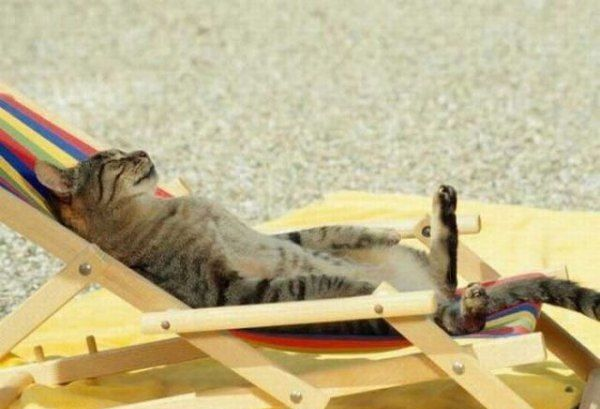